In [157]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    torch.cuda.manual_seed_all(777)
print(device + " is available")
 
learning_rate = 0.001
batch = 4
epochs = 200

cuda is available


In [158]:
import cv2
import numpy as np
import os
from PIL import Image
from collections import Counter

test = Image.open('./train_set/target/1.png')
data_dir = os.listdir('./train_set/data')
target_dir = os.listdir('./train_set/target')
train_set = [Image.open('./train_set/data/'+dir).resize((512,512)) for dir in data_dir]
target_set = [Image.open('./train_set/target/'+dir).resize((512,512)) for dir in target_dir]

In [159]:
x = train_set
y = target_set


In [160]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
x_train, x_valid, y_train,  y_valid = train_test_split(x_train, y_train, test_size=0.25, shuffle=True )

In [161]:
from typing import Any


class Normalization(object):
  def __init__(self, mean=0.5 , std=0.5):
    self.mean = mean
    self.std = std
  
  def __call__(self, data):

    data =(data - self.mean) / self.std

    return data

class image2np(object):
  def __init__(self, label):
    self.label = label

  def __call__(self, img):
    img = np.array(img, dtype=np.float32)
    if img.ndim == 2:
      img = img[:, :, np.newaxis]
    if self.label:
      img = np.where(img == 0, 0, 255)
    return img/255
  
class img2coor(object):
  def __call__(self, img):
    x, y = np.nonzero(img)
    return torch.Tensor(np.array([x[0],y[0],x[-1],y[-1]])) # top left bottom right
  
import selectivesearch 

def selective(img, label):
    _, region = selectivesearch.selective_search(img, scale = 50, min_size=2000)
    cand_rects = [cand['rect'] for cand in region]
    # res = []
    for rect in cand_rects:
        
        left = rect[0]
        top = rect[1]
        right = left + rect[2]
        bottom = top + rect[3]
        tmp = torch.tensor(np.array([top,left,bottom,right]))
        if intersection_over_union(tmp, label) > 0.6:
           return np.array([top,left,bottom,right])

def intersection_over_union(boxes_preds, boxes_labels, box_format='corners'):

    if box_format == 'corners':
        box1_y1 = boxes_preds[..., 0:1]
        box1_x1 = boxes_preds[..., 1:2]
        box1_y2 = boxes_preds[..., 2:3]
        box1_x2 = boxes_preds[..., 3:4]
        box2_y1 = boxes_labels[..., 0:1]
        box2_x1 = boxes_labels[..., 1:2]
        box2_y2 = boxes_labels[..., 2:3]
        box2_x2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # bounding box 교차지역 존재 x
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    return intersection / (box1_area + box2_area - intersection + 1e-6)


In [162]:
import albumentations as a

def image_printer(flag,x_res,y_res):
    if flag:
            plt.subplot(1,2,1)
            plt.imshow(transforms.ToPILImage()((x_res*255).astype(np.uint8)))
            plt.subplot(1,2,2)
            plt.imshow(transforms.ToPILImage()((y_res*255).astype(np.uint8)))
            plt.show()

def image_preprocess(img_arr, target_arr, train = False, valid = False, test = False):
    flag = 1
    blur = a.OneOf([
                a.MotionBlur(p=1),
                a.OpticalDistortion(p=1)           
    ], p=1)
    x_res = []
    y_res = []
    x_compose = [
        Normalization(mean= 0.5, std =0.5),
        transforms.ToTensor()
    ]
    y_compose = [
        img2coor()
    ]
    
    tf1 = transforms.Compose(x_compose)
    tf2 = transforms.Compose(y_compose)

    if train:
        for new_img,target in zip(image2np(label=False)(img_arr),image2np(label=True)(target_arr)):
            res = a.VerticalFlip(p=1)(image = new_img, mask = target)
            image_printer(flag,res['image'],res['mask'])
            x = selective(blur(image = res['image'])['image'],tf2(res['mask']))
            if x is not None:
                x_res.append(x)
                y_res.append(tf2(res['mask']))

            res = a.HorizontalFlip(p=1)(image = new_img, mask = target)
            image_printer(flag,res['image'],res['mask'])
            x = selective(blur(image = res['image'])['image'],tf2(res['mask']))
            if x is not None:
                x_res.append(x)
                y_res.append(tf2(res['mask']))

            res = a.Affine(p=1)(image = new_img, mask = target)
            image_printer(flag,res['image'],res['mask'])
            x = selective(blur(image = res['image'])['image'],tf2(res['mask']))
            if x is not None:
                x_res.append(x)
                y_res.append(tf2(res['mask']))

            x = selective(new_img, tf2(target))
            if x is not None:
                x_res.append(x)
                y_res.append(tf2(target))
            flag = 0
    if valid:
        for new_img,target in zip(image2np(label=False)(img_arr),image2np(label=True)(target_arr)):            
            x = selective(new_img, tf2(target))
            if x is not None:
                x_res.append(x)
                y_res.append(tf2(target))
    if test:
        for new_img,target in zip(image2np(label=False)(img_arr),image2np(label=True)(target_arr)):            
            x_res.append(tf1(new_img))
            y_res.append(tf2(target))
    return np.array(x_res), np.array(y_res)

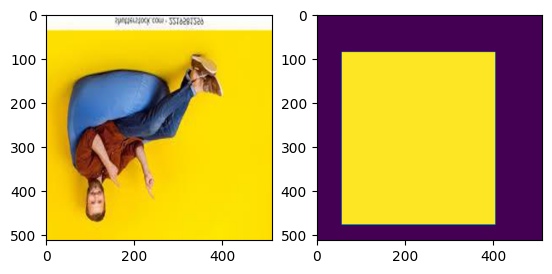

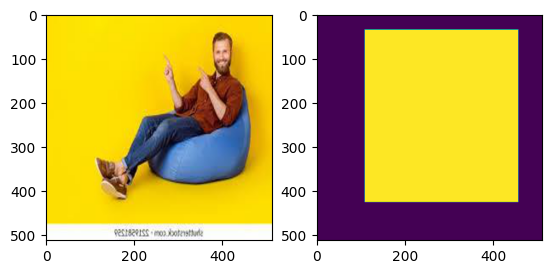

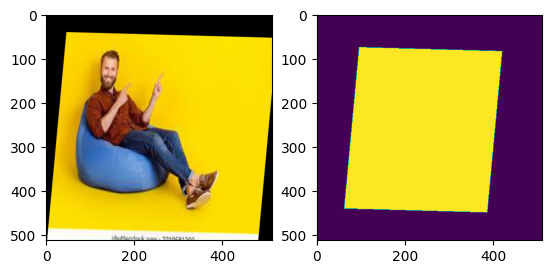

In [163]:
# 이미지 전처리 적용
x_train, y_train = image_preprocess(x_train, y_train, train=True)
x_valid, y_valid = image_preprocess(x_valid, y_valid, valid=True)
x_test, y_test = image_preprocess(x_test, y_test, test=True)


In [164]:
print(x_train.shape, x_valid.shape, x_test.shape)

(135, 4) (10, 4) (22, 3, 512, 512)


In [165]:
from torch.utils.data import TensorDataset, DataLoader

print(torch.tensor(x_train).shape,torch.tensor(np.array(y_train)).shape)
traindata = TensorDataset(torch.tensor(x_train),torch.tensor(np.array(y_train)))
validdata = TensorDataset(torch.tensor(x_valid),torch.tensor(np.array(y_valid)))
testdata = TensorDataset(torch.tensor(x_test),torch.tensor(np.array(y_test)))

trainLoader = DataLoader(
    traindata,
    batch_size=batch,
    shuffle = True
)
validLoader = DataLoader(
    validdata,
    batch_size=batch,
    shuffle = True
)
testLoader = DataLoader(
    testdata,
    batch_size=1,
    shuffle = True
)
# transforms.ToPILImage()(torch.stack(x_train)[0])


torch.Size([135, 4]) torch.Size([135, 4])


In [166]:
class bounding_regression(nn.Module):
    def __init__(self):
        super(bounding_regression, self).__init__()
      
        self.fc1 = nn.Linear(4,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,16)
        self.fc4 = nn.Linear(16,4)
        self.drop = nn.Dropout(p=0.50)

    def forward(self, x):

        fc1 = F.relu(self.fc1(x))
        x = self.drop(x)
        fc2 = F.relu(self.fc2(fc1))
        x = self.drop(x)
        fc3 = F.relu(self.fc3(fc2))
        x = self.drop(x)
        fc4 = self.fc4(fc3)
    
        return fc4

In [167]:
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)[0]

def preview(img, c1, c2):
    img = fn_tonumpy(img)
    copy = img.copy()
    c = (0,10,0)
    text = 'before'
    coor = 40
    for rect in [c1[0],c2[0]]:    
      top = int(rect[0])
      left = int(rect[1])
      bottom = int(rect[2])
      right = int(rect[3])
      copy = cv2.rectangle(copy, (left,top), (right,bottom),color=c,thickness=2)
      cv2.putText(copy, text,(left,top+coor) , cv2.FONT_HERSHEY_DUPLEX, .8, c)
      c = (255,0,10)
      text = 'after'
      coor = 120
    plt.imshow(copy)
    plt.show()

def make_tensor(data, label):
   res_data, res_label = [], []
   for d, t in zip(data,label):
      tmp = selective(d.numpy().transpose(1,2,0),t)
      if tmp is not None:
        res_data.append(tmp)
        res_label.append(t)
   return torch.tensor(np.array(res_data)), torch.tensor(np.array(res_label))

In [168]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

rgb_model = bounding_regression().to(device) 
rgb_model.apply(initialize_weights)

optimizer = torch.optim.Adam(rgb_model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience=3, eps = 1e-05) 
train_avg_cost = []
train_acc = []
valid_avg_cost = [] 
valid_acc = []
lr = []

for epoch in range(epochs): 
    rgb_model.train()
    avg_cost = 0
    correct = 0
    total = 0
    lr.append(optimizer.param_groups[0]['lr'])
    for data, target in trainLoader:
        data = data.float().to(device)
        target = target.to(device)
        optimizer.zero_grad() 
        hypothesis = rgb_model(data)
        criterion = torchvision.ops.complete_box_iou_loss(hypothesis, target, 'mean').to(device)
        cost = criterion
        total += len(target)
        for i in range(len(hypothesis)):
                correct += intersection_over_union(hypothesis[i],target[i]) 
        cost.backward() 
        optimizer.step()
        avg_cost += cost / len(trainLoader)
        
    train_avg_cost.append(float(avg_cost))
    train_acc.append(correct/total)
    avg_cost = 0
    correct = 0
    total = 0

    rgb_model.eval() 
    with torch.no_grad(): 
        for data, target in validLoader:
            data = data.float().to(device)
            target = target.to(device)
            hypothesis = rgb_model(data) 
            total += len(target)
            for i in range(len(hypothesis)):
                correct += intersection_over_union(hypothesis[i],target[i]) 
            avg_cost += cost / len(trainLoader)
        valid_avg_cost.append(float(avg_cost))
        valid_acc.append(correct/total)
    scheduler.step(valid_avg_cost[-1])
    if epoch % 10 == 0:
        torch.save(rgb_model, f'model{epoch}.pt')
    print('[Epoch: {:>4}] traincost = {:>.9} validcost = {:>.9}'.format(epoch + 1, train_avg_cost[-1],valid_avg_cost[-1]))

if device == 'cuda':
    torch.cuda.empty_cache() 

[Epoch:    1] traincost = 0.929438055 validcost = 0.066277571
[Epoch:    2] traincost = 0.65945524 validcost = 0.0385086052
[Epoch:    3] traincost = 0.417971432 validcost = 0.0284846071
[Epoch:    4] traincost = 0.352414101 validcost = 0.0232598092
[Epoch:    5] traincost = 0.338232368 validcost = 0.0194011014
[Epoch:    6] traincost = 0.329314232 validcost = 0.0210228823
[Epoch:    7] traincost = 0.318557471 validcost = 0.0229929592
[Epoch:    8] traincost = 0.322938859 validcost = 0.0292928331
[Epoch:    9] traincost = 0.325331986 validcost = 0.0323312394
[Epoch:   10] traincost = 0.310043633 validcost = 0.0183903556
[Epoch:   11] traincost = 0.292853057 validcost = 0.0261789076
[Epoch:   12] traincost = 0.289516956 validcost = 0.0280444287
[Epoch:   13] traincost = 0.288844347 validcost = 0.0328238308
[Epoch:   14] traincost = 0.289155006 validcost = 0.0231375918
[Epoch:   15] traincost = 0.28577894 validcost = 0.03192164
[Epoch:   16] traincost = 0.284686148 validcost = 0.02509299

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


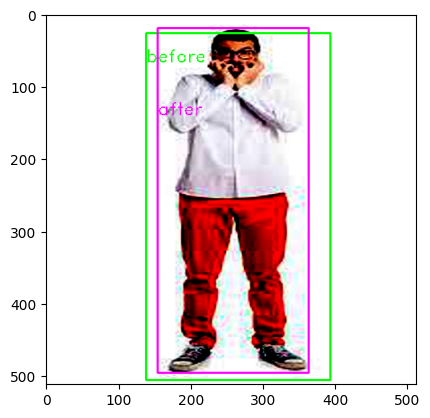

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


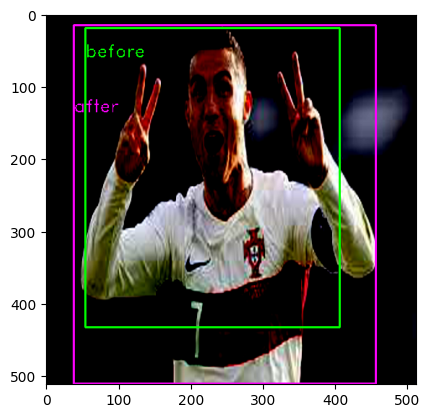

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


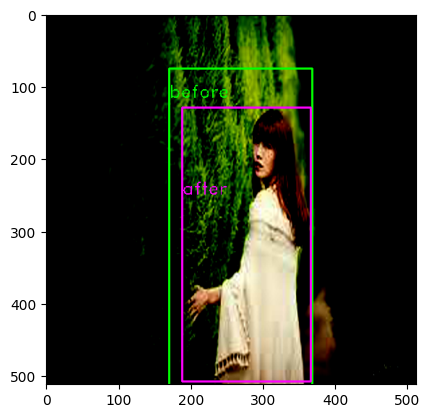

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


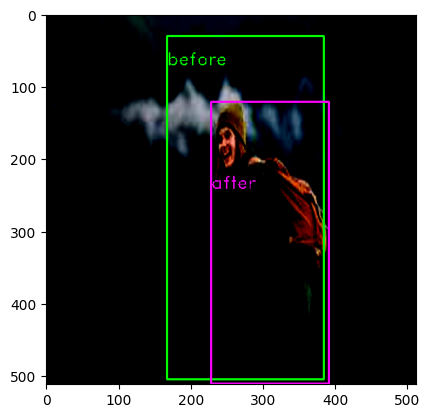

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


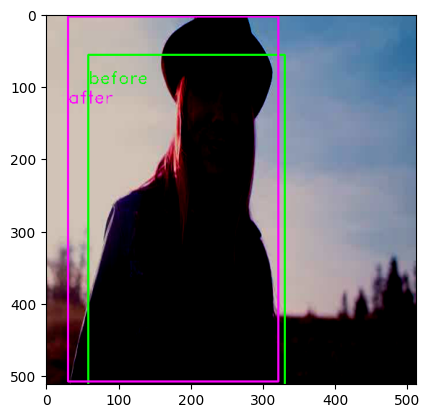

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


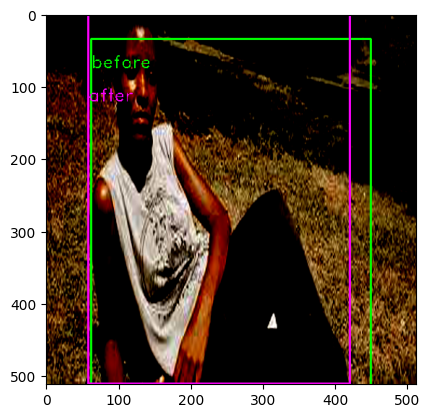

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


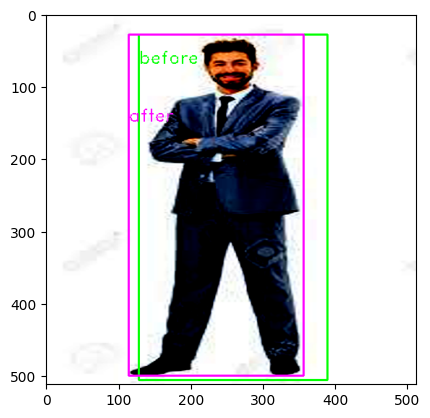

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


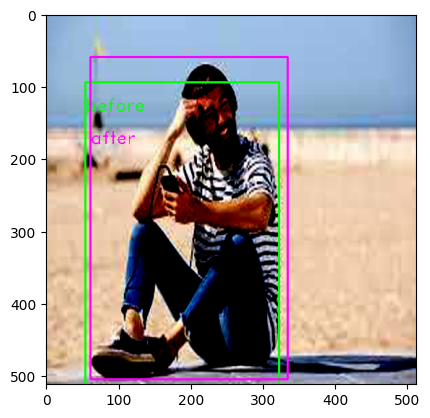

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


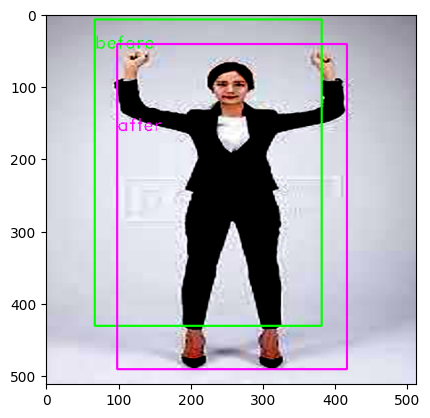

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


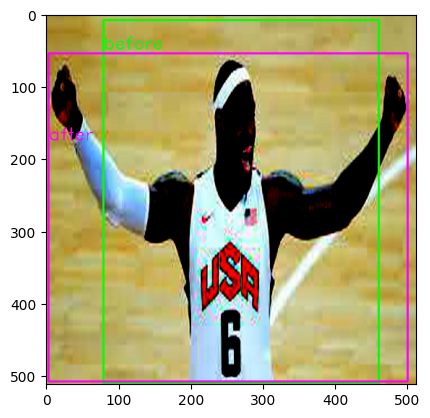

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


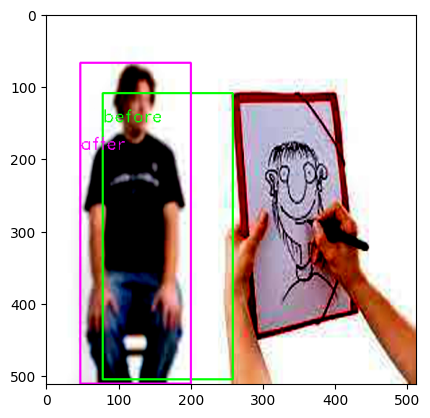

Test Accuracy:  71.95082092285156 %


In [169]:
rgb_model.eval() 
with torch.no_grad(): 
    correct = 0
    total = 0

    for data, target in testLoader:
        img = data
        data, target = make_tensor(data, target)
        
        if len(data) == 0:
            continue
        data = data.float().to(device)
        target = target.to(device)
        hypothesis = rgb_model(data) 
        for i in range(len(hypothesis)):
                correct += intersection_over_union(hypothesis[i],target[i])
        total += len(target) 
        preview(img, hypothesis, target)
        
        
    print('Test Accuracy: ', float(100.*correct/total), '%')

if device == 'cuda':
    torch.cuda.empty_cache() 

C:\Users\dkstn\AppData\Local\Temp\ipykernel_14976\722296320.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


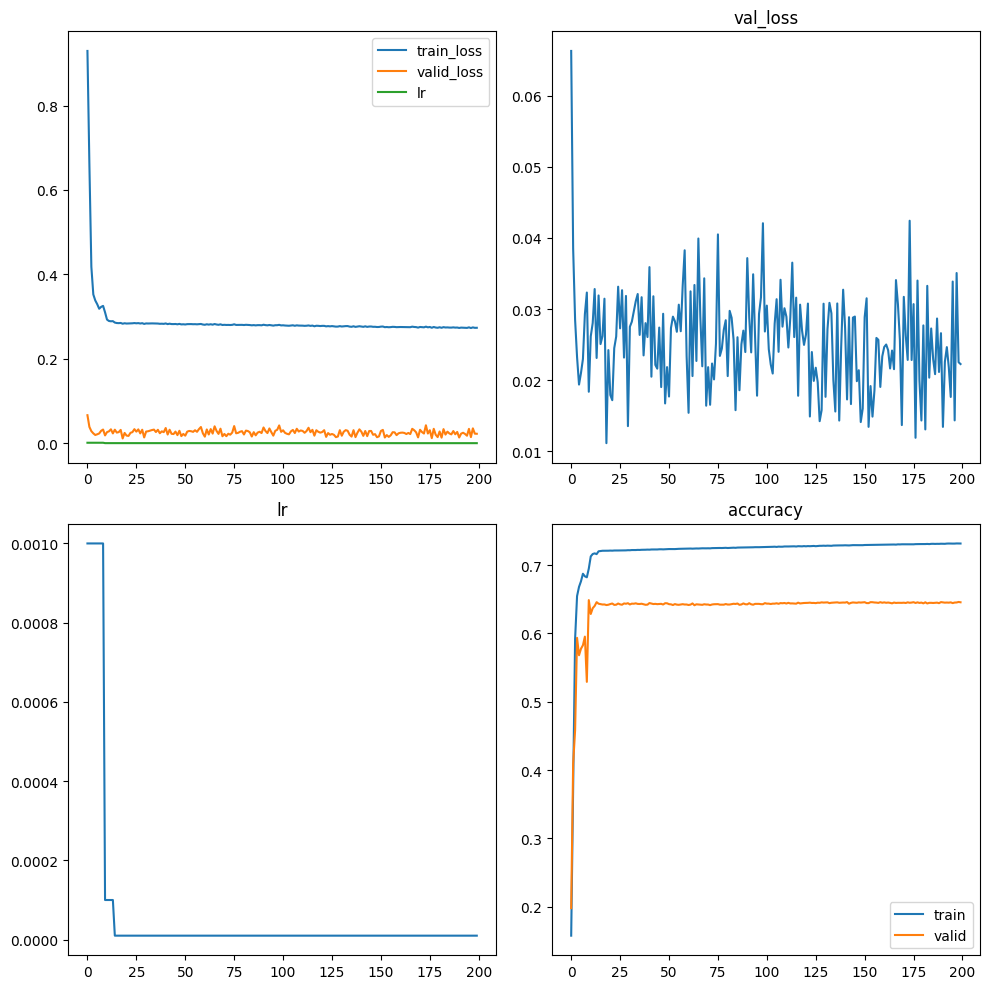

In [170]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('rgb_model')
plt.subplot(2,2,1)
plt.plot(range(epochs), train_avg_cost)
plt.plot(range(epochs), valid_avg_cost)
plt.plot(range(epochs), lr)
plt.legend(['train_loss','valid_loss','lr'])

plt.subplot(2,2,2)
plt.plot(valid_avg_cost)
plt.title('val_loss')

plt.subplot(2,2,3)
plt.plot(lr)
plt.title('lr')

plt.subplot(2,2,4)
plt.title('accuracy')
plt.plot(range(epochs), list(map(float,train_acc)))
plt.plot(range(epochs), list(map(float,valid_acc)))
plt.legend(['train','valid'])
plt.subplots_adjust(hspace=1)
plt.tight_layout()
plt.show()